# Expert Autoencoder-based Multi-Class Classifier
## One Autoencoder per Class with Reconstruction Loss-based Classification

This notebook implements a unique classification approach:
- Train one autoencoder for each class (Forest, Highway, Industrial, Pasture)
- Each autoencoder learns to reconstruct only its own class
- Classification is based on reconstruction loss:
  - The class with the lowest reconstruction loss is assigned
  - If all losses are above a threshold, the image is classified as "Unknown"
- This allows for multi-label classification and OOD (Out-of-Distribution) detection

## 1. Import Libraries

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import json

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Configuration

In [20]:
# Paths
DATA_ROOT = r"c:\Users\houss\Desktop\JC-2\MTL_Classification_Reconstruction\data"

# Classes
CLASSES = ['Forest', 'Highway', 'Industrial', 'Pasture']
NUM_CLASSES = len(CLASSES)

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 64
LATENT_DIM = 128

# Train/Val split
TRAIN_SPLIT = 0.8

# Classification threshold
UNKNOWN_THRESHOLD = 0.1  # Reconstruction loss threshold for "unknown" class
MULTI_LABEL_THRESHOLD = 0.05  # If multiple classes have loss below this, assign multiple labels

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Data Loading

In [21]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [22]:
class SingleClassDataset(Dataset):
    """Dataset for a single class"""
    
    def __init__(self, root_dir, class_name, transform=None):
        self.root_dir = root_dir
        self.class_name = class_name
        self.transform = transform
        self.samples = []
        
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist!")
            return
        
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                img_path = os.path.join(class_dir, img_name)
                self.samples.append(img_path)
        
        print(f"Loaded {len(self.samples)} images for class '{class_name}'")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, image  # Return image twice (input and target for autoencoder)

In [23]:
class MultiClassDataset(Dataset):
    """Dataset for all classes (for evaluation)"""
    
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.samples = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} does not exist!")
                continue
            
            class_idx = self.class_to_idx[class_name]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"\nMultiClass Dataset: {len(self.samples)} total images")
        for cls in classes:
            count = sum(1 for _, label in self.samples if label == self.class_to_idx[cls])
            print(f"  {cls}: {count} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [24]:
# Create datasets for each class
class_datasets = {}
class_train_loaders = {}
class_val_loaders = {}

print("Loading individual class datasets...\n")
for class_name in CLASSES:
    # Load full dataset for this class
    full_dataset = SingleClassDataset(DATA_ROOT, class_name, transform=None)
    
    # Split into train and validation
    train_size = int(TRAIN_SPLIT * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Apply transforms
    train_dataset.dataset.transform = train_transforms
    val_dataset.dataset.transform = val_transforms
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    class_train_loaders[class_name] = train_loader
    class_val_loaders[class_name] = val_loader
    
    print(f"{class_name}: {len(train_dataset)} train, {len(val_dataset)} val")

print("\n" + "="*50)

Loading individual class datasets...

Loaded 3000 images for class 'Forest'
Forest: 2400 train, 600 val
Forest: 2400 train, 600 val
Loaded 2500 images for class 'Highway'
Highway: 2000 train, 500 val
Loaded 2500 images for class 'Industrial'
Industrial: 2000 train, 500 val
Loaded 2500 images for class 'Highway'
Highway: 2000 train, 500 val
Loaded 2500 images for class 'Industrial'
Industrial: 2000 train, 500 val
Loaded 2000 images for class 'Pasture'
Pasture: 1600 train, 400 val

Loaded 2000 images for class 'Pasture'
Pasture: 1600 train, 400 val



In [25]:
# Create a combined validation dataset for evaluation
print("\nCreating combined validation dataset...")
combined_val_dataset = MultiClassDataset(DATA_ROOT, CLASSES, transform=val_transforms)

# Split for validation
all_indices = list(range(len(combined_val_dataset)))
np.random.shuffle(all_indices)
val_size = int(0.2 * len(combined_val_dataset))
val_indices = all_indices[:val_size]
val_subset = Subset(combined_val_dataset, val_indices)
combined_val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Validation set: {len(val_subset)} images")


Creating combined validation dataset...

MultiClass Dataset: 10000 total images
  Forest: 3000 images
  Highway: 2500 images
  Industrial: 2500 images
  Pasture: 2000 images
Validation set: 2000 images


## 4. Autoencoder Architecture

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64 x 16 x 16
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128 x 8 x 8
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 x 4 x 4
            nn.ReLU(True),
            nn.BatchNorm2d(256),
        )
        
        # Latent space
        self.fc_encoder = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, 256 * 4 * 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            # Input: 256 x 4 x 4
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128 x 8 x 8
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64 x 16 x 16
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 3 x 64 x 64
            nn.Sigmoid()  # Output in [0, 1] range
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc_encoder(x)
        return x
    
    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

# Test model
test_model = Autoencoder(LATENT_DIM).to(device)
test_input = torch.randn(1, 3, 64, 64).to(device)
test_output = test_model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
del test_model, test_input, test_output

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])
Model parameters: 2,434,243


## 5. Training Functions

In [27]:
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, num_epochs, class_name):
    """Train a single autoencoder for one class"""
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"\nTraining autoencoder for class: {class_name}")
    print("="*60)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, targets in pbar:
            images, targets = images.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"  ✓ Best model updated (Val Loss: {val_loss:.6f})")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f"\nBest validation loss for {class_name}: {best_val_loss:.6f}\n")
    
    return model, history, best_val_loss

## 6. Train Autoencoders for Each Class

In [28]:
# Initialize models and optimizers
autoencoders = {}
histories = {}
best_val_losses = {}

criterion = nn.MSELoss()

# Train one autoencoder for each class
for class_name in CLASSES:
    print("\n" + "#"*60)
    print(f"# Training autoencoder for: {class_name}")
    print("#"*60)
    
    # Initialize model
    model = Autoencoder(LATENT_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train
    model, history, best_loss = train_autoencoder(
        model=model,
        train_loader=class_train_loaders[class_name],
        val_loader=class_val_loaders[class_name],
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        class_name=class_name
    )
    
    autoencoders[class_name] = model
    histories[class_name] = history
    best_val_losses[class_name] = best_loss
    
    # Save model
    torch.save(model.state_dict(), f'autoencoder_{class_name.lower()}.pth')
    print(f"Model saved as 'autoencoder_{class_name.lower()}.pth'")

print("\n" + "="*60)
print("All autoencoders trained successfully!")
print("="*60)
print("\nBest validation losses:")
for class_name, loss in best_val_losses.items():
    print(f"  {class_name}: {loss:.6f}")


############################################################
# Training autoencoder for: Forest
############################################################

Training autoencoder for class: Forest


Epoch 1/50 [Train]: 100%|██████████| 75/75 [00:10<00:00,  7.48it/s, loss=0.022565]



Epoch 1/50 - Train Loss: 0.042755, Val Loss: 0.066552
  ✓ Best model updated (Val Loss: 0.066552)


Epoch 2/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.32it/s, loss=0.007566]



Epoch 2/50 - Train Loss: 0.009682, Val Loss: 0.007197
  ✓ Best model updated (Val Loss: 0.007197)


Epoch 3/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.41it/s, loss=0.002998]



Epoch 3/50 - Train Loss: 0.004559, Val Loss: 0.002075
  ✓ Best model updated (Val Loss: 0.002075)


Epoch 4/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.27it/s, loss=0.001027]



Epoch 4/50 - Train Loss: 0.001851, Val Loss: 0.001614
  ✓ Best model updated (Val Loss: 0.001614)


Epoch 5/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.52it/s, loss=0.002119]



Epoch 5/50 - Train Loss: 0.001592, Val Loss: 0.001816


Epoch 6/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.58it/s, loss=0.001316]



Epoch 6/50 - Train Loss: 0.001556, Val Loss: 0.001380
  ✓ Best model updated (Val Loss: 0.001380)


Epoch 7/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.48it/s, loss=0.001190]



Epoch 7/50 - Train Loss: 0.001197, Val Loss: 0.001073
  ✓ Best model updated (Val Loss: 0.001073)


Epoch 8/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.65it/s, loss=0.000633]



Epoch 8/50 - Train Loss: 0.000892, Val Loss: 0.000941
  ✓ Best model updated (Val Loss: 0.000941)


Epoch 9/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.52it/s, loss=0.000834]



Epoch 9/50 - Train Loss: 0.000779, Val Loss: 0.000775
  ✓ Best model updated (Val Loss: 0.000775)


Epoch 10/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.49it/s, loss=0.000578]



Epoch 10/50 - Train Loss: 0.000713, Val Loss: 0.000743
  ✓ Best model updated (Val Loss: 0.000743)


Epoch 11/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.59it/s, loss=0.000590]



Epoch 11/50 - Train Loss: 0.000652, Val Loss: 0.000683
  ✓ Best model updated (Val Loss: 0.000683)


Epoch 12/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.58it/s, loss=0.000587]



Epoch 12/50 - Train Loss: 0.000611, Val Loss: 0.000598
  ✓ Best model updated (Val Loss: 0.000598)


Epoch 13/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.44it/s, loss=0.000917]



Epoch 13/50 - Train Loss: 0.000577, Val Loss: 0.000818


Epoch 14/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.34it/s, loss=0.001311]



Epoch 14/50 - Train Loss: 0.000627, Val Loss: 0.000803


Epoch 15/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.29it/s, loss=0.000569]



Epoch 15/50 - Train Loss: 0.000547, Val Loss: 0.000466
  ✓ Best model updated (Val Loss: 0.000466)


Epoch 16/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.44it/s, loss=0.000442]



Epoch 16/50 - Train Loss: 0.000457, Val Loss: 0.000439
  ✓ Best model updated (Val Loss: 0.000439)


Epoch 17/50 [Train]: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, loss=0.000342]



Epoch 17/50 - Train Loss: 0.000431, Val Loss: 0.000412
  ✓ Best model updated (Val Loss: 0.000412)


Epoch 18/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.47it/s, loss=0.000415]



Epoch 18/50 - Train Loss: 0.000404, Val Loss: 0.000396
  ✓ Best model updated (Val Loss: 0.000396)


Epoch 19/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.13it/s, loss=0.000363]


Epoch 19/50 - Train Loss: 0.000403, Val Loss: 0.000391
  ✓ Best model updated (Val Loss: 0.000391)


Epoch 20/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s, loss=0.000359]



Epoch 20/50 - Train Loss: 0.000375, Val Loss: 0.000390
  ✓ Best model updated (Val Loss: 0.000390)


Epoch 21/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.13it/s, loss=0.000441]



Epoch 21/50 - Train Loss: 0.000387, Val Loss: 0.000362
  ✓ Best model updated (Val Loss: 0.000362)


Epoch 22/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.37it/s, loss=0.000285]



Epoch 22/50 - Train Loss: 0.000380, Val Loss: 0.000372


Epoch 23/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.39it/s, loss=0.000392]



Epoch 23/50 - Train Loss: 0.000366, Val Loss: 0.000353
  ✓ Best model updated (Val Loss: 0.000353)


Epoch 24/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.33it/s, loss=0.000407]



Epoch 24/50 - Train Loss: 0.000360, Val Loss: 0.000358


Epoch 25/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.56it/s, loss=0.000271]



Epoch 25/50 - Train Loss: 0.000351, Val Loss: 0.000346
  ✓ Best model updated (Val Loss: 0.000346)


Epoch 26/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.57it/s, loss=0.000340]



Epoch 26/50 - Train Loss: 0.000355, Val Loss: 0.000394


Epoch 27/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.26it/s, loss=0.000373]



Epoch 27/50 - Train Loss: 0.000363, Val Loss: 0.000368


Epoch 28/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.46it/s, loss=0.000462]



Epoch 28/50 - Train Loss: 0.000351, Val Loss: 0.000356


Epoch 29/50 [Train]: 100%|██████████| 75/75 [00:09<00:00,  7.64it/s, loss=0.000350]



Epoch 29/50 - Train Loss: 0.000350, Val Loss: 0.000379


Epoch 30/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.69it/s, loss=0.000277]



Epoch 30/50 - Train Loss: 0.000343, Val Loss: 0.000389


Epoch 31/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.29it/s, loss=0.000325]



Epoch 31/50 - Train Loss: 0.000342, Val Loss: 0.000412


Epoch 32/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.43it/s, loss=0.000325]



Epoch 32/50 - Train Loss: 0.000338, Val Loss: 0.000455


Epoch 33/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.81it/s, loss=0.000310]



Epoch 33/50 - Train Loss: 0.000334, Val Loss: 0.000359


Epoch 34/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.52it/s, loss=0.001123]



Epoch 34/50 - Train Loss: 0.001044, Val Loss: 0.002290


Epoch 35/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.42it/s, loss=0.000977]



Epoch 35/50 - Train Loss: 0.000982, Val Loss: 0.000830


Epoch 36/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.33it/s, loss=0.000774]



Epoch 36/50 - Train Loss: 0.000699, Val Loss: 0.000769


Epoch 37/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.35it/s, loss=0.000567]



Epoch 37/50 - Train Loss: 0.000603, Val Loss: 0.000607


Epoch 38/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.96it/s, loss=0.000436]



Epoch 38/50 - Train Loss: 0.000548, Val Loss: 0.000565


Epoch 39/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.38it/s, loss=0.000460]



Epoch 39/50 - Train Loss: 0.000520, Val Loss: 0.000530


Epoch 40/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.91it/s, loss=0.000578]



Epoch 40/50 - Train Loss: 0.000495, Val Loss: 0.000499


Epoch 41/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.23it/s, loss=0.000553]



Epoch 41/50 - Train Loss: 0.000463, Val Loss: 0.000451


Epoch 42/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  9.34it/s, loss=0.000383]



Epoch 42/50 - Train Loss: 0.000449, Val Loss: 0.000437


Epoch 43/50 [Train]: 100%|██████████| 75/75 [00:07<00:00,  9.41it/s, loss=0.000362]



Epoch 43/50 - Train Loss: 0.000441, Val Loss: 0.000435


Epoch 44/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.93it/s, loss=0.000765]



Epoch 44/50 - Train Loss: 0.000421, Val Loss: 0.000420


Epoch 45/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.74it/s, loss=0.000314]



Epoch 45/50 - Train Loss: 0.000422, Val Loss: 0.000413


Epoch 46/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.82it/s, loss=0.000376]



Epoch 46/50 - Train Loss: 0.000406, Val Loss: 0.000403


Epoch 47/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.72it/s, loss=0.000312]



Epoch 47/50 - Train Loss: 0.000383, Val Loss: 0.000382


Epoch 48/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.74it/s, loss=0.000325]



Epoch 48/50 - Train Loss: 0.000395, Val Loss: 0.000380


Epoch 49/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.81it/s, loss=0.000439]



Epoch 49/50 - Train Loss: 0.000382, Val Loss: 0.000382


Epoch 50/50 [Train]: 100%|██████████| 75/75 [00:08<00:00,  8.85it/s, loss=0.000396]



Epoch 50/50 - Train Loss: 0.000377, Val Loss: 0.000382

Best validation loss for Forest: 0.000346

Model saved as 'autoencoder_forest.pth'

############################################################
# Training autoencoder for: Highway
############################################################

Training autoencoder for class: Highway


Epoch 1/50 [Train]: 100%|██████████| 63/63 [00:22<00:00,  2.85it/s, loss=0.016482]



Epoch 1/50 - Train Loss: 0.021099, Val Loss: 0.009917
  ✓ Best model updated (Val Loss: 0.009917)


Epoch 2/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.15it/s, loss=0.035228]



Epoch 2/50 - Train Loss: 0.011069, Val Loss: 0.010024


Epoch 3/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.02it/s, loss=0.010029]



Epoch 3/50 - Train Loss: 0.009871, Val Loss: 0.008330
  ✓ Best model updated (Val Loss: 0.008330)


Epoch 4/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.00it/s, loss=0.006117]



Epoch 4/50 - Train Loss: 0.008455, Val Loss: 0.006880
  ✓ Best model updated (Val Loss: 0.006880)


Epoch 5/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.87it/s, loss=0.005855]



Epoch 5/50 - Train Loss: 0.007344, Val Loss: 0.007133


Epoch 6/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.90it/s, loss=0.005878]



Epoch 6/50 - Train Loss: 0.007347, Val Loss: 0.006422
  ✓ Best model updated (Val Loss: 0.006422)


Epoch 7/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s, loss=0.008645]



Epoch 7/50 - Train Loss: 0.006949, Val Loss: 0.007273


Epoch 8/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.007381]



Epoch 8/50 - Train Loss: 0.006989, Val Loss: 0.006820


Epoch 9/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.55it/s, loss=0.005889]



Epoch 9/50 - Train Loss: 0.006486, Val Loss: 0.005772
  ✓ Best model updated (Val Loss: 0.005772)


Epoch 10/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.12it/s, loss=0.006709]



Epoch 10/50 - Train Loss: 0.006044, Val Loss: 0.005490
  ✓ Best model updated (Val Loss: 0.005490)


Epoch 11/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.04it/s, loss=0.004772]



Epoch 11/50 - Train Loss: 0.006011, Val Loss: 0.005606


Epoch 12/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.02it/s, loss=0.014784]



Epoch 12/50 - Train Loss: 0.005794, Val Loss: 0.005082
  ✓ Best model updated (Val Loss: 0.005082)


Epoch 13/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s, loss=0.006080]



Epoch 13/50 - Train Loss: 0.005341, Val Loss: 0.005144


Epoch 14/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s, loss=0.005630]



Epoch 14/50 - Train Loss: 0.005517, Val Loss: 0.004959
  ✓ Best model updated (Val Loss: 0.004959)


Epoch 15/50 [Train]: 100%|██████████| 63/63 [00:08<00:00,  7.71it/s, loss=0.005426]



Epoch 15/50 - Train Loss: 0.005259, Val Loss: 0.004792
  ✓ Best model updated (Val Loss: 0.004792)


Epoch 16/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.49it/s, loss=0.004895]



Epoch 16/50 - Train Loss: 0.005046, Val Loss: 0.004848


Epoch 17/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.84it/s, loss=0.006316]



Epoch 17/50 - Train Loss: 0.005110, Val Loss: 0.004955


Epoch 18/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s, loss=0.005906]



Epoch 18/50 - Train Loss: 0.005126, Val Loss: 0.004544
  ✓ Best model updated (Val Loss: 0.004544)


Epoch 19/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.01it/s, loss=0.006463]



Epoch 19/50 - Train Loss: 0.004799, Val Loss: 0.004634


Epoch 20/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.72it/s, loss=0.004103]



Epoch 20/50 - Train Loss: 0.004525, Val Loss: 0.004267
  ✓ Best model updated (Val Loss: 0.004267)


Epoch 21/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.82it/s, loss=0.005002]



Epoch 21/50 - Train Loss: 0.004457, Val Loss: 0.004562


Epoch 22/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.82it/s, loss=0.006047]



Epoch 22/50 - Train Loss: 0.004343, Val Loss: 0.004518


Epoch 23/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.89it/s, loss=0.005306]


Epoch 23/50 - Train Loss: 0.004232, Val Loss: 0.004231
  ✓ Best model updated (Val Loss: 0.004231)


Epoch 24/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.82it/s, loss=0.005620]



Epoch 24/50 - Train Loss: 0.004412, Val Loss: 0.004041
  ✓ Best model updated (Val Loss: 0.004041)


Epoch 25/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.89it/s, loss=0.005434]



Epoch 25/50 - Train Loss: 0.004039, Val Loss: 0.004022
  ✓ Best model updated (Val Loss: 0.004022)


Epoch 26/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.00it/s, loss=0.006871]



Epoch 26/50 - Train Loss: 0.003982, Val Loss: 0.003933
  ✓ Best model updated (Val Loss: 0.003933)


Epoch 27/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.85it/s, loss=0.007211]



Epoch 27/50 - Train Loss: 0.004571, Val Loss: 0.006599


Epoch 28/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.00it/s, loss=0.004181]



Epoch 28/50 - Train Loss: 0.004835, Val Loss: 0.004027


Epoch 29/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.90it/s, loss=0.005594]



Epoch 29/50 - Train Loss: 0.004159, Val Loss: 0.004073


Epoch 30/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.08it/s, loss=0.004612]



Epoch 30/50 - Train Loss: 0.004298, Val Loss: 0.004142


Epoch 31/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.76it/s, loss=0.003564]



Epoch 31/50 - Train Loss: 0.004024, Val Loss: 0.004099


Epoch 32/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.42it/s, loss=0.004099]



Epoch 32/50 - Train Loss: 0.003876, Val Loss: 0.004260


Epoch 33/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.85it/s, loss=0.003900]



Epoch 33/50 - Train Loss: 0.003794, Val Loss: 0.003793
  ✓ Best model updated (Val Loss: 0.003793)


Epoch 34/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.83it/s, loss=0.004208]



Epoch 34/50 - Train Loss: 0.003677, Val Loss: 0.003857


Epoch 35/50 [Train]: 100%|██████████| 63/63 [00:08<00:00,  7.46it/s, loss=0.004651]



Epoch 35/50 - Train Loss: 0.003618, Val Loss: 0.003782
  ✓ Best model updated (Val Loss: 0.003782)


Epoch 36/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.12it/s, loss=0.005114]



Epoch 36/50 - Train Loss: 0.003538, Val Loss: 0.003814


Epoch 37/50 [Train]: 100%|██████████| 63/63 [00:08<00:00,  7.40it/s, loss=0.002831]



Epoch 37/50 - Train Loss: 0.003473, Val Loss: 0.003924


Epoch 38/50 [Train]: 100%|██████████| 63/63 [00:09<00:00,  6.58it/s, loss=0.004310]



Epoch 38/50 - Train Loss: 0.003637, Val Loss: 0.004306


Epoch 39/50 [Train]: 100%|██████████| 63/63 [00:08<00:00,  7.82it/s, loss=0.002875]



Epoch 39/50 - Train Loss: 0.003481, Val Loss: 0.003739
  ✓ Best model updated (Val Loss: 0.003739)


Epoch 40/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.49it/s, loss=0.003569]



Epoch 40/50 - Train Loss: 0.003534, Val Loss: 0.003933


Epoch 41/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.53it/s, loss=0.004296]



Epoch 41/50 - Train Loss: 0.003323, Val Loss: 0.003885


Epoch 42/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.29it/s, loss=0.005583]



Epoch 42/50 - Train Loss: 0.003426, Val Loss: 0.003940


Epoch 43/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.05it/s, loss=0.003945]



Epoch 43/50 - Train Loss: 0.003300, Val Loss: 0.003965


Epoch 44/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.002979]



Epoch 44/50 - Train Loss: 0.003292, Val Loss: 0.003830


Epoch 45/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.90it/s, loss=0.003644]



Epoch 45/50 - Train Loss: 0.003102, Val Loss: 0.003867


Epoch 46/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.82it/s, loss=0.003181]



Epoch 46/50 - Train Loss: 0.003148, Val Loss: 0.004160


Epoch 47/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.92it/s, loss=0.003014]



Epoch 47/50 - Train Loss: 0.003166, Val Loss: 0.004087


Epoch 48/50 [Train]: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s, loss=0.004337]



Epoch 48/50 - Train Loss: 0.003301, Val Loss: 0.005214


Epoch 49/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.37it/s, loss=0.003696]



Epoch 49/50 - Train Loss: 0.003213, Val Loss: 0.003935


Epoch 50/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.95it/s, loss=0.003496]



Epoch 50/50 - Train Loss: 0.003049, Val Loss: 0.003893

Best validation loss for Highway: 0.003739

Model saved as 'autoencoder_highway.pth'

############################################################
# Training autoencoder for: Industrial
############################################################

Training autoencoder for class: Industrial


Epoch 1/50 [Train]: 100%|██████████| 63/63 [00:23<00:00,  2.74it/s, loss=0.023607]



Epoch 1/50 - Train Loss: 0.031646, Val Loss: 0.023159
  ✓ Best model updated (Val Loss: 0.023159)


Epoch 2/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.04it/s, loss=0.024539]



Epoch 2/50 - Train Loss: 0.021987, Val Loss: 0.019399
  ✓ Best model updated (Val Loss: 0.019399)


Epoch 3/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.83it/s, loss=0.018467]


Epoch 3/50 - Train Loss: 0.019048, Val Loss: 0.017039
  ✓ Best model updated (Val Loss: 0.017039)


Epoch 4/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.95it/s, loss=0.015962]



Epoch 4/50 - Train Loss: 0.016821, Val Loss: 0.015394
  ✓ Best model updated (Val Loss: 0.015394)


Epoch 5/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s, loss=0.019182]



Epoch 5/50 - Train Loss: 0.015449, Val Loss: 0.014408
  ✓ Best model updated (Val Loss: 0.014408)


Epoch 6/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.89it/s, loss=0.016038]



Epoch 6/50 - Train Loss: 0.014382, Val Loss: 0.013661
  ✓ Best model updated (Val Loss: 0.013661)


Epoch 7/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s, loss=0.013661]



Epoch 7/50 - Train Loss: 0.013610, Val Loss: 0.013459
  ✓ Best model updated (Val Loss: 0.013459)


Epoch 8/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.92it/s, loss=0.013430]


Epoch 8/50 - Train Loss: 0.013113, Val Loss: 0.012698
  ✓ Best model updated (Val Loss: 0.012698)


Epoch 9/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.84it/s, loss=0.013098]



Epoch 9/50 - Train Loss: 0.012364, Val Loss: 0.012374
  ✓ Best model updated (Val Loss: 0.012374)


Epoch 10/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.90it/s, loss=0.013448]



Epoch 10/50 - Train Loss: 0.011915, Val Loss: 0.011957
  ✓ Best model updated (Val Loss: 0.011957)


Epoch 11/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.03it/s, loss=0.011443]



Epoch 11/50 - Train Loss: 0.011139, Val Loss: 0.011744
  ✓ Best model updated (Val Loss: 0.011744)


Epoch 12/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.97it/s, loss=0.012365]



Epoch 12/50 - Train Loss: 0.010710, Val Loss: 0.011251
  ✓ Best model updated (Val Loss: 0.011251)


Epoch 13/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s, loss=0.012214]



Epoch 13/50 - Train Loss: 0.010190, Val Loss: 0.011417


Epoch 14/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.96it/s, loss=0.009290]


Epoch 14/50 - Train Loss: 0.009888, Val Loss: 0.010974
  ✓ Best model updated (Val Loss: 0.010974)


Epoch 15/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s, loss=0.009656]



Epoch 15/50 - Train Loss: 0.009493, Val Loss: 0.010917
  ✓ Best model updated (Val Loss: 0.010917)


Epoch 16/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.95it/s, loss=0.008655]



Epoch 16/50 - Train Loss: 0.009044, Val Loss: 0.010735
  ✓ Best model updated (Val Loss: 0.010735)


Epoch 17/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.90it/s, loss=0.008493]



Epoch 17/50 - Train Loss: 0.008797, Val Loss: 0.010914


Epoch 18/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s, loss=0.008126]



Epoch 18/50 - Train Loss: 0.008389, Val Loss: 0.010728
  ✓ Best model updated (Val Loss: 0.010728)


Epoch 19/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.01it/s, loss=0.009489]



Epoch 19/50 - Train Loss: 0.008268, Val Loss: 0.011272


Epoch 20/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.72it/s, loss=0.008006]



Epoch 20/50 - Train Loss: 0.007982, Val Loss: 0.010824


Epoch 21/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.02it/s, loss=0.007750]



Epoch 21/50 - Train Loss: 0.007822, Val Loss: 0.010994


Epoch 22/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s, loss=0.007768]



Epoch 22/50 - Train Loss: 0.007564, Val Loss: 0.010950


Epoch 23/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.03it/s, loss=0.006594]



Epoch 23/50 - Train Loss: 0.007230, Val Loss: 0.010953


Epoch 24/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.88it/s, loss=0.007203]



Epoch 24/50 - Train Loss: 0.007245, Val Loss: 0.011125


Epoch 25/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.59it/s, loss=0.006939]



Epoch 25/50 - Train Loss: 0.006961, Val Loss: 0.011142


Epoch 26/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  9.00it/s, loss=0.006865]



Epoch 26/50 - Train Loss: 0.006992, Val Loss: 0.011416


Epoch 27/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.006480]



Epoch 27/50 - Train Loss: 0.006706, Val Loss: 0.011222


Epoch 28/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.96it/s, loss=0.007091]



Epoch 28/50 - Train Loss: 0.006641, Val Loss: 0.011283


Epoch 29/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.007238]



Epoch 29/50 - Train Loss: 0.006435, Val Loss: 0.011512


Epoch 30/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.03it/s, loss=0.007066]


Epoch 30/50 - Train Loss: 0.006221, Val Loss: 0.011534


Epoch 31/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.00it/s, loss=0.006965]



Epoch 31/50 - Train Loss: 0.006280, Val Loss: 0.011356


Epoch 32/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s, loss=0.005377]



Epoch 32/50 - Train Loss: 0.006224, Val Loss: 0.011927


Epoch 33/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.04it/s, loss=0.006218]



Epoch 33/50 - Train Loss: 0.006084, Val Loss: 0.011565


Epoch 34/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.007314]



Epoch 34/50 - Train Loss: 0.005983, Val Loss: 0.011571


Epoch 35/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.91it/s, loss=0.006287]



Epoch 35/50 - Train Loss: 0.005835, Val Loss: 0.011695


Epoch 36/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s, loss=0.005816]



Epoch 36/50 - Train Loss: 0.005712, Val Loss: 0.011611


Epoch 37/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.05it/s, loss=0.005857]



Epoch 37/50 - Train Loss: 0.005680, Val Loss: 0.011791


Epoch 38/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.00it/s, loss=0.006698]



Epoch 38/50 - Train Loss: 0.005640, Val Loss: 0.011725


Epoch 39/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  9.00it/s, loss=0.007287]



Epoch 39/50 - Train Loss: 0.005540, Val Loss: 0.011748


Epoch 40/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.83it/s, loss=0.005877]



Epoch 40/50 - Train Loss: 0.005497, Val Loss: 0.012041


Epoch 41/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.98it/s, loss=0.005533]


Epoch 41/50 - Train Loss: 0.005365, Val Loss: 0.012207


Epoch 42/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.95it/s, loss=0.005646]



Epoch 42/50 - Train Loss: 0.005464, Val Loss: 0.011968


Epoch 43/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.005874]



Epoch 43/50 - Train Loss: 0.005343, Val Loss: 0.012051


Epoch 44/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, loss=0.005637]



Epoch 44/50 - Train Loss: 0.005248, Val Loss: 0.011929


Epoch 45/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.94it/s, loss=0.005128]



Epoch 45/50 - Train Loss: 0.005117, Val Loss: 0.012138


Epoch 46/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.89it/s, loss=0.005024]



Epoch 46/50 - Train Loss: 0.005063, Val Loss: 0.012061


Epoch 47/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.01it/s, loss=0.005121]



Epoch 47/50 - Train Loss: 0.005042, Val Loss: 0.012241


Epoch 48/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s, loss=0.006103]


Epoch 48/50 - Train Loss: 0.004995, Val Loss: 0.012109


Epoch 49/50 [Train]: 100%|██████████| 63/63 [00:07<00:00,  8.78it/s, loss=0.004924]



Epoch 49/50 - Train Loss: 0.004932, Val Loss: 0.012455


Epoch 50/50 [Train]: 100%|██████████| 63/63 [00:06<00:00,  9.05it/s, loss=0.006117]



Epoch 50/50 - Train Loss: 0.004876, Val Loss: 0.012136

Best validation loss for Industrial: 0.010728

Model saved as 'autoencoder_industrial.pth'

############################################################
# Training autoencoder for: Pasture
############################################################

Training autoencoder for class: Pasture


Epoch 1/50 [Train]: 100%|██████████| 50/50 [00:17<00:00,  2.78it/s, loss=0.013958]



Epoch 1/50 - Train Loss: 0.026522, Val Loss: 0.007746
  ✓ Best model updated (Val Loss: 0.007746)


Epoch 2/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.14it/s, loss=0.011649]



Epoch 2/50 - Train Loss: 0.009586, Val Loss: 0.011267


Epoch 3/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.78it/s, loss=0.006649]



Epoch 3/50 - Train Loss: 0.007119, Val Loss: 0.005800
  ✓ Best model updated (Val Loss: 0.005800)


Epoch 4/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s, loss=0.003706]



Epoch 4/50 - Train Loss: 0.004936, Val Loss: 0.004327
  ✓ Best model updated (Val Loss: 0.004327)


Epoch 5/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.97it/s, loss=0.003420]



Epoch 5/50 - Train Loss: 0.003829, Val Loss: 0.003309
  ✓ Best model updated (Val Loss: 0.003309)


Epoch 6/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.84it/s, loss=0.003246]



Epoch 6/50 - Train Loss: 0.003304, Val Loss: 0.002964
  ✓ Best model updated (Val Loss: 0.002964)


Epoch 7/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.85it/s, loss=0.002905]



Epoch 7/50 - Train Loss: 0.002877, Val Loss: 0.002534
  ✓ Best model updated (Val Loss: 0.002534)


Epoch 8/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s, loss=0.002684]



Epoch 8/50 - Train Loss: 0.002652, Val Loss: 0.005789


Epoch 9/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.83it/s, loss=0.002964]



Epoch 9/50 - Train Loss: 0.002578, Val Loss: 0.002761


Epoch 10/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.02it/s, loss=0.002032]



Epoch 10/50 - Train Loss: 0.002431, Val Loss: 0.002395
  ✓ Best model updated (Val Loss: 0.002395)


Epoch 11/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.91it/s, loss=0.002410]



Epoch 11/50 - Train Loss: 0.002456, Val Loss: 0.068087


Epoch 12/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s, loss=0.003071]



Epoch 12/50 - Train Loss: 0.003258, Val Loss: 0.002758


Epoch 13/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.91it/s, loss=0.002255]



Epoch 13/50 - Train Loss: 0.002771, Val Loss: 0.002590


Epoch 14/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.77it/s, loss=0.002788]



Epoch 14/50 - Train Loss: 0.002593, Val Loss: 0.002434


Epoch 15/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s, loss=0.002684]



Epoch 15/50 - Train Loss: 0.002562, Val Loss: 0.002382
  ✓ Best model updated (Val Loss: 0.002382)


Epoch 16/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s, loss=0.002421]



Epoch 16/50 - Train Loss: 0.002449, Val Loss: 0.002206
  ✓ Best model updated (Val Loss: 0.002206)


Epoch 17/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.91it/s, loss=0.002041]



Epoch 17/50 - Train Loss: 0.002290, Val Loss: 0.002104
  ✓ Best model updated (Val Loss: 0.002104)


Epoch 18/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.99it/s, loss=0.002244]



Epoch 18/50 - Train Loss: 0.002298, Val Loss: 0.002084
  ✓ Best model updated (Val Loss: 0.002084)


Epoch 19/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.84it/s, loss=0.001991]



Epoch 19/50 - Train Loss: 0.002206, Val Loss: 0.001989
  ✓ Best model updated (Val Loss: 0.001989)


Epoch 20/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s, loss=0.001949]



Epoch 20/50 - Train Loss: 0.002146, Val Loss: 0.001992


Epoch 21/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.05it/s, loss=0.001932]



Epoch 21/50 - Train Loss: 0.002084, Val Loss: 0.001895
  ✓ Best model updated (Val Loss: 0.001895)


Epoch 22/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s, loss=0.001871]



Epoch 22/50 - Train Loss: 0.002051, Val Loss: 0.001885
  ✓ Best model updated (Val Loss: 0.001885)


Epoch 23/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.75it/s, loss=0.001840]



Epoch 23/50 - Train Loss: 0.002006, Val Loss: 0.001978


Epoch 24/50 [Train]: 100%|██████████| 50/50 [00:06<00:00,  8.33it/s, loss=0.001937]



Epoch 24/50 - Train Loss: 0.001928, Val Loss: 0.001858
  ✓ Best model updated (Val Loss: 0.001858)


Epoch 25/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.99it/s, loss=0.001597]



Epoch 25/50 - Train Loss: 0.001882, Val Loss: 0.001719
  ✓ Best model updated (Val Loss: 0.001719)


Epoch 26/50 [Train]: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s, loss=0.001716]



Epoch 26/50 - Train Loss: 0.001865, Val Loss: 0.001660
  ✓ Best model updated (Val Loss: 0.001660)


Epoch 27/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.42it/s, loss=0.002219]



Epoch 27/50 - Train Loss: 0.001806, Val Loss: 0.001665


Epoch 28/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s, loss=0.001729]



Epoch 28/50 - Train Loss: 0.001749, Val Loss: 0.001575
  ✓ Best model updated (Val Loss: 0.001575)


Epoch 29/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.79it/s, loss=0.001873]



Epoch 29/50 - Train Loss: 0.001702, Val Loss: 0.001645


Epoch 30/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.88it/s, loss=0.001770]



Epoch 30/50 - Train Loss: 0.001650, Val Loss: 0.001772


Epoch 31/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s, loss=0.001632]



Epoch 31/50 - Train Loss: 0.001723, Val Loss: 0.001623


Epoch 32/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.79it/s, loss=0.001367]



Epoch 32/50 - Train Loss: 0.001607, Val Loss: 0.001489
  ✓ Best model updated (Val Loss: 0.001489)


Epoch 33/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s, loss=0.001321]



Epoch 33/50 - Train Loss: 0.001593, Val Loss: 0.001515


Epoch 34/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.98it/s, loss=0.001438]



Epoch 34/50 - Train Loss: 0.001569, Val Loss: 0.001476
  ✓ Best model updated (Val Loss: 0.001476)


Epoch 35/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.76it/s, loss=0.001379]



Epoch 35/50 - Train Loss: 0.001514, Val Loss: 0.001439
  ✓ Best model updated (Val Loss: 0.001439)


Epoch 36/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.88it/s, loss=0.001554]



Epoch 36/50 - Train Loss: 0.001550, Val Loss: 0.001429
  ✓ Best model updated (Val Loss: 0.001429)


Epoch 37/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.86it/s, loss=0.001478]



Epoch 37/50 - Train Loss: 0.001488, Val Loss: 0.001483


Epoch 38/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.80it/s, loss=0.001287]



Epoch 38/50 - Train Loss: 0.001499, Val Loss: 0.001507


Epoch 39/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.90it/s, loss=0.001447]



Epoch 39/50 - Train Loss: 0.001495, Val Loss: 0.001525


Epoch 40/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s, loss=0.001504]



Epoch 40/50 - Train Loss: 0.001490, Val Loss: 0.001342
  ✓ Best model updated (Val Loss: 0.001342)


Epoch 41/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s, loss=0.001262]



Epoch 41/50 - Train Loss: 0.001455, Val Loss: 0.001484


Epoch 42/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s, loss=0.001407]



Epoch 42/50 - Train Loss: 0.001443, Val Loss: 0.001389


Epoch 43/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.67it/s, loss=0.001469]



Epoch 43/50 - Train Loss: 0.001468, Val Loss: 0.001345


Epoch 44/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.79it/s, loss=0.001459]



Epoch 44/50 - Train Loss: 0.001385, Val Loss: 0.001336
  ✓ Best model updated (Val Loss: 0.001336)


Epoch 45/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.04it/s, loss=0.001134]



Epoch 45/50 - Train Loss: 0.001424, Val Loss: 0.001319
  ✓ Best model updated (Val Loss: 0.001319)


Epoch 46/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.91it/s, loss=0.001138]



Epoch 46/50 - Train Loss: 0.001370, Val Loss: 0.001266
  ✓ Best model updated (Val Loss: 0.001266)


Epoch 47/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.70it/s, loss=0.001090]



Epoch 47/50 - Train Loss: 0.001381, Val Loss: 0.001501


Epoch 48/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.88it/s, loss=0.001220]



Epoch 48/50 - Train Loss: 0.001335, Val Loss: 0.001234
  ✓ Best model updated (Val Loss: 0.001234)


Epoch 49/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s, loss=0.001319]



Epoch 49/50 - Train Loss: 0.001340, Val Loss: 0.001275


Epoch 50/50 [Train]: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s, loss=0.001459]



Epoch 50/50 - Train Loss: 0.001316, Val Loss: 0.001194
  ✓ Best model updated (Val Loss: 0.001194)

Best validation loss for Pasture: 0.001194

Model saved as 'autoencoder_pasture.pth'

All autoencoders trained successfully!

Best validation losses:
  Forest: 0.000346
  Highway: 0.003739
  Industrial: 0.010728
  Pasture: 0.001194


## 7. Visualize Training History

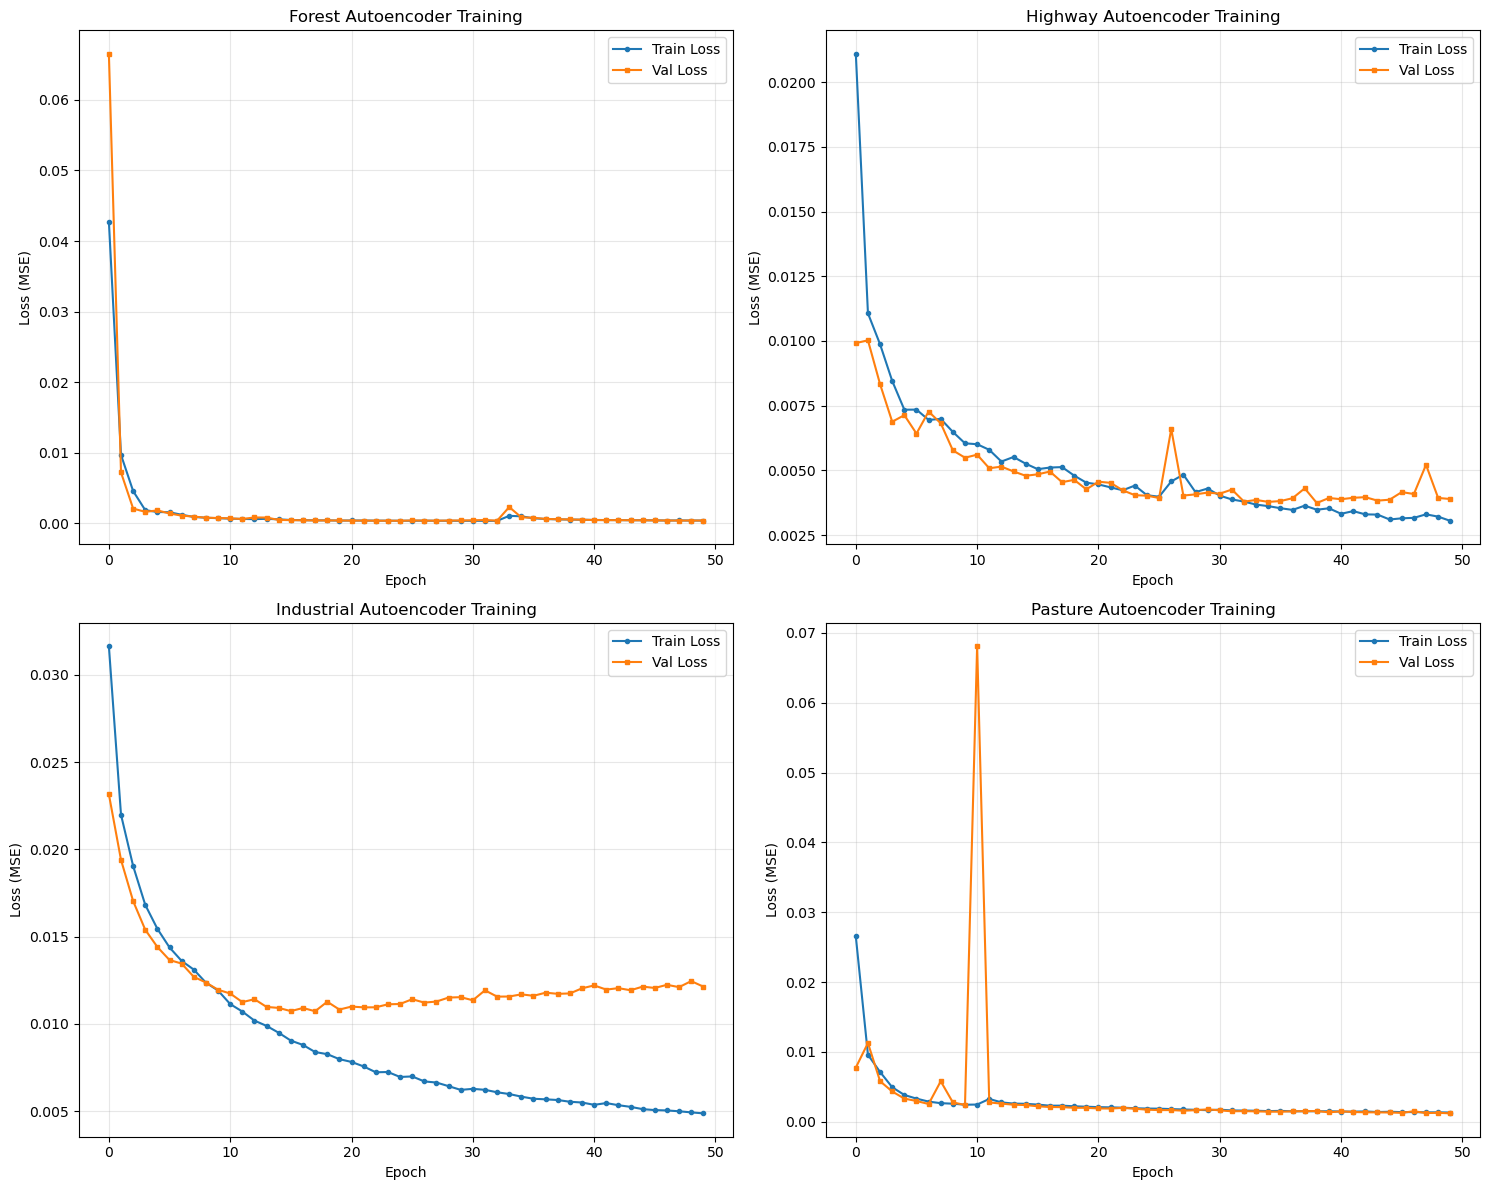

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, class_name in enumerate(CLASSES):
    history = histories[class_name]
    
    axes[idx].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
    axes[idx].plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss (MSE)')
    axes[idx].set_title(f'{class_name} Autoencoder Training')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoencoder_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Visualize Reconstructions

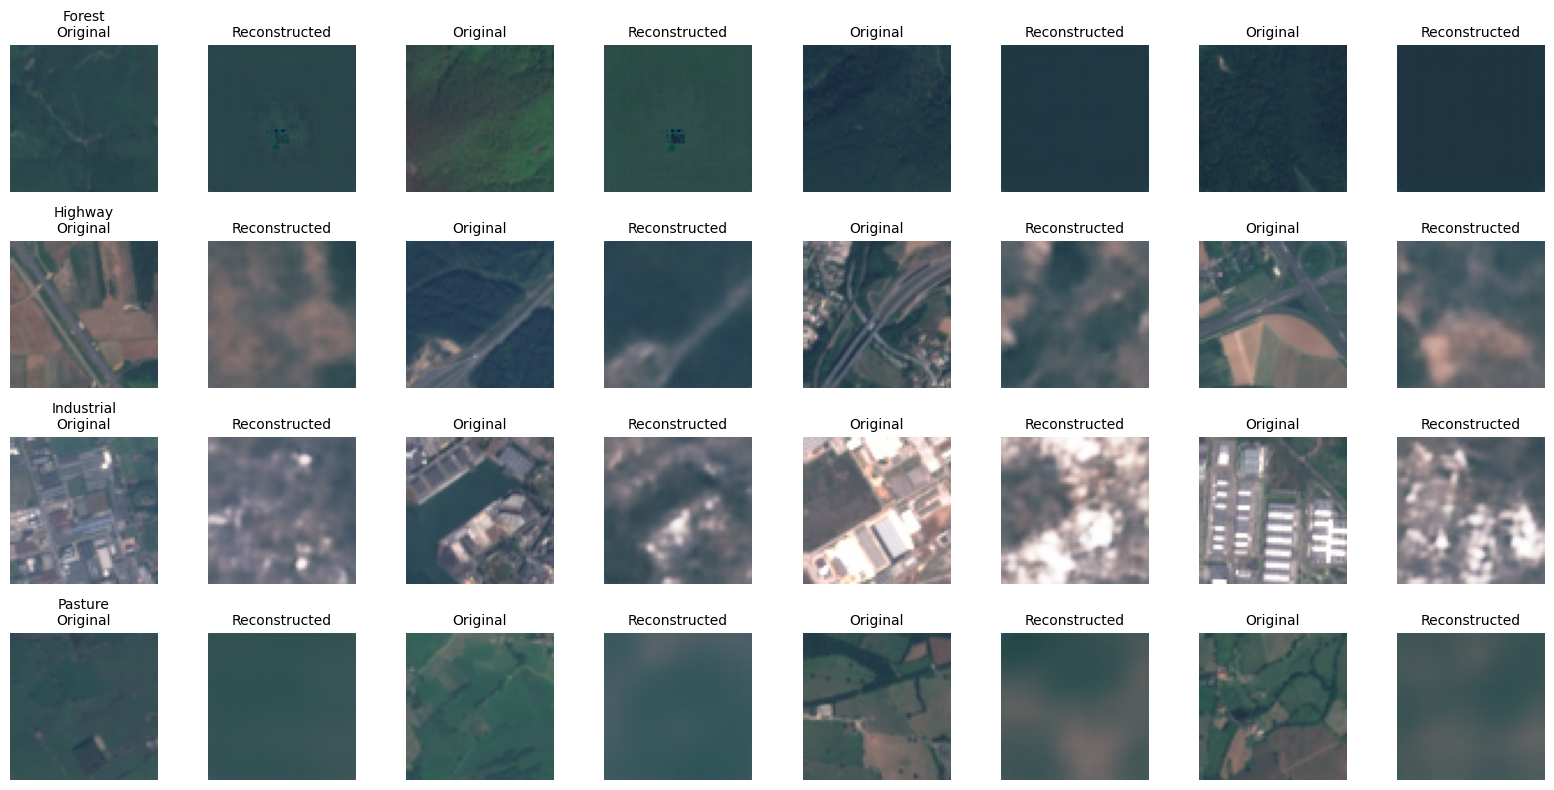

In [30]:
def visualize_reconstructions(autoencoders, class_loaders, classes, num_samples=4):
    """Visualize reconstructions from each autoencoder"""
    
    fig, axes = plt.subplots(len(classes), num_samples * 2, figsize=(num_samples * 4, len(classes) * 2))
    
    for class_idx, class_name in enumerate(classes):
        model = autoencoders[class_name]
        model.eval()
        
        # Get a batch of images
        dataiter = iter(class_loaders[class_name])
        images, _ = next(dataiter)
        images = images[:num_samples].to(device)
        
        with torch.no_grad():
            reconstructed = model(images)
        
        # Plot original and reconstructed
        for i in range(num_samples):
            # Original
            img_orig = images[i].cpu().numpy().transpose(1, 2, 0)
            axes[class_idx, i*2].imshow(np.clip(img_orig, 0, 1))
            axes[class_idx, i*2].axis('off')
            if i == 0:
                axes[class_idx, i*2].set_title(f'{class_name}\nOriginal', fontsize=10)
            else:
                axes[class_idx, i*2].set_title('Original', fontsize=10)
            
            # Reconstructed
            img_recon = reconstructed[i].cpu().numpy().transpose(1, 2, 0)
            axes[class_idx, i*2+1].imshow(np.clip(img_recon, 0, 1))
            axes[class_idx, i*2+1].axis('off')
            axes[class_idx, i*2+1].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('autoencoder_reconstructions.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_reconstructions(autoencoders, class_val_loaders, CLASSES)

## 9. Classification Based on Reconstruction Loss

In [31]:
def compute_reconstruction_loss(model, image):
    """Compute reconstruction loss for a single image"""
    model.eval()
    with torch.no_grad():
        reconstructed = model(image)
        loss = nn.MSELoss(reduction='mean')(reconstructed, image)
    return loss.item()

def classify_image(image, autoencoders, classes, unknown_threshold, multi_label_threshold=None):
    """Classify an image based on reconstruction losses"""
    
    # Compute reconstruction loss for each autoencoder
    losses = {}
    for class_name in classes:
        loss = compute_reconstruction_loss(autoencoders[class_name], image)
        losses[class_name] = loss
    
    # Find minimum loss
    min_loss = min(losses.values())
    
    # Single-label classification
    if min_loss > unknown_threshold:
        return 'Unknown', losses, min_loss
    
    predicted_class = min(losses, key=losses.get)
    
    # Multi-label classification (if enabled)
    if multi_label_threshold is not None:
        predicted_classes = [cls for cls, loss in losses.items() if loss < multi_label_threshold]
        if len(predicted_classes) > 1:
            return predicted_classes, losses, min_loss
    
    return predicted_class, losses, min_loss

## 10. Evaluate on Validation Set

In [32]:
def evaluate_classifier(autoencoders, val_loader, classes, unknown_threshold, class_to_idx):
    """Evaluate the autoencoder-based classifier"""
    
    all_true_labels = []
    all_pred_labels = []
    all_losses_matrix = []
    unknown_count = 0
    
    print("Evaluating classifier on validation set...")
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        
        for i in range(len(images)):
            image = images[i:i+1]
            true_label = labels[i].item()
            
            # Classify
            predicted, losses, min_loss = classify_image(
                image, autoencoders, classes, unknown_threshold
            )
            
            all_true_labels.append(true_label)
            
            if predicted == 'Unknown':
                all_pred_labels.append(len(classes))  # Unknown class index
                unknown_count += 1
            elif isinstance(predicted, list):
                # Multi-label: take the first one for confusion matrix
                all_pred_labels.append(class_to_idx[predicted[0]])
            else:
                all_pred_labels.append(class_to_idx[predicted])
            
            # Store all losses
            loss_vector = [losses[cls] for cls in classes]
            all_losses_matrix.append(loss_vector)
    
    print(f"\nTotal images: {len(all_true_labels)}")
    print(f"Classified as 'Unknown': {unknown_count} ({100*unknown_count/len(all_true_labels):.2f}%)")
    
    return all_true_labels, all_pred_labels, np.array(all_losses_matrix)

# Run evaluation
class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
true_labels, pred_labels, losses_matrix = evaluate_classifier(
    autoencoders, combined_val_loader, CLASSES, UNKNOWN_THRESHOLD, class_to_idx
)

Evaluating classifier on validation set...


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Total images: 2000
Classified as 'Unknown': 0 (0.00%)


## 11. Compute Metrics and Confusion Matrix

In [33]:
# Filter out 'Unknown' predictions for accuracy calculation
filtered_true = []
filtered_pred = []

for true, pred in zip(true_labels, pred_labels):
    if pred < len(CLASSES):  # Not 'Unknown'
        filtered_true.append(true)
        filtered_pred.append(pred)

if len(filtered_true) > 0:
    accuracy = accuracy_score(filtered_true, filtered_pred)
    print(f"\nAccuracy (excluding 'Unknown'): {accuracy*100:.2f}%")
    
    # Classification report
    print("\nClassification Report (excluding 'Unknown'):")
    print(classification_report(filtered_true, filtered_pred, target_names=CLASSES, zero_division=0))
else:
    print("All images classified as 'Unknown'!")


Accuracy (excluding 'Unknown'): 73.60%

Classification Report (excluding 'Unknown'):
              precision    recall  f1-score   support

      Forest       1.00      0.55      0.71       602
     Highway       0.52      0.93      0.66       498
  Industrial       0.93      0.99      0.96       513
     Pasture       0.76      0.43      0.55       387

    accuracy                           0.74      2000
   macro avg       0.80      0.73      0.72      2000
weighted avg       0.81      0.74      0.73      2000



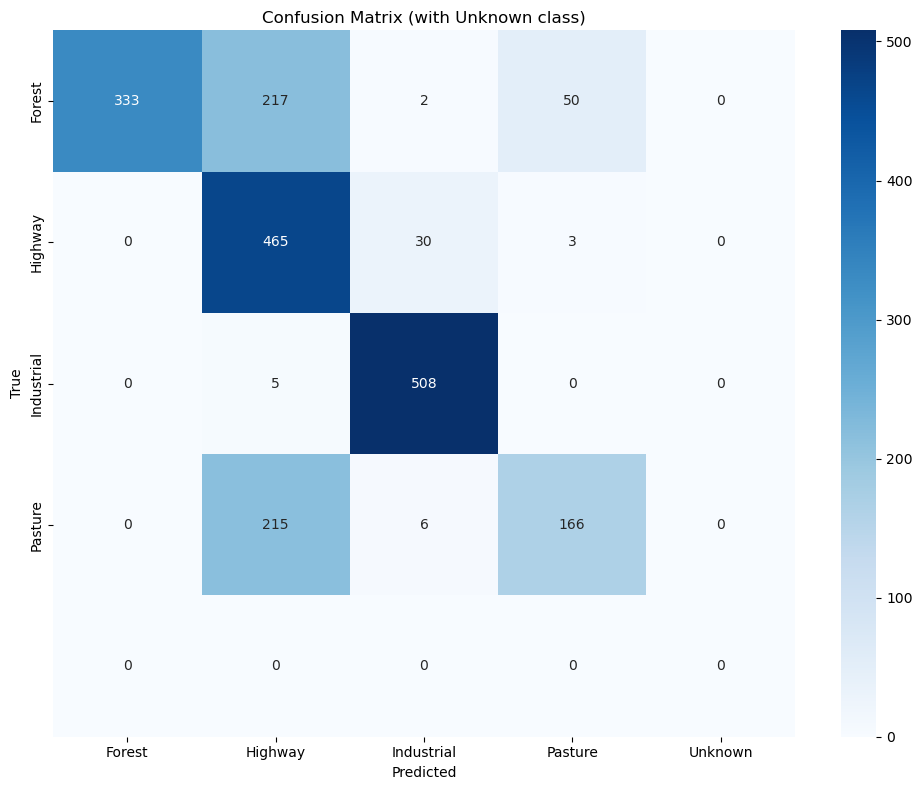

In [34]:
# Confusion matrix (including 'Unknown' class)
class_names_with_unknown = CLASSES + ['Unknown']
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(class_names_with_unknown))))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_with_unknown,
            yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (with Unknown class)')
plt.tight_layout()
plt.savefig('confusion_matrix_with_unknown.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Analyze Reconstruction Losses

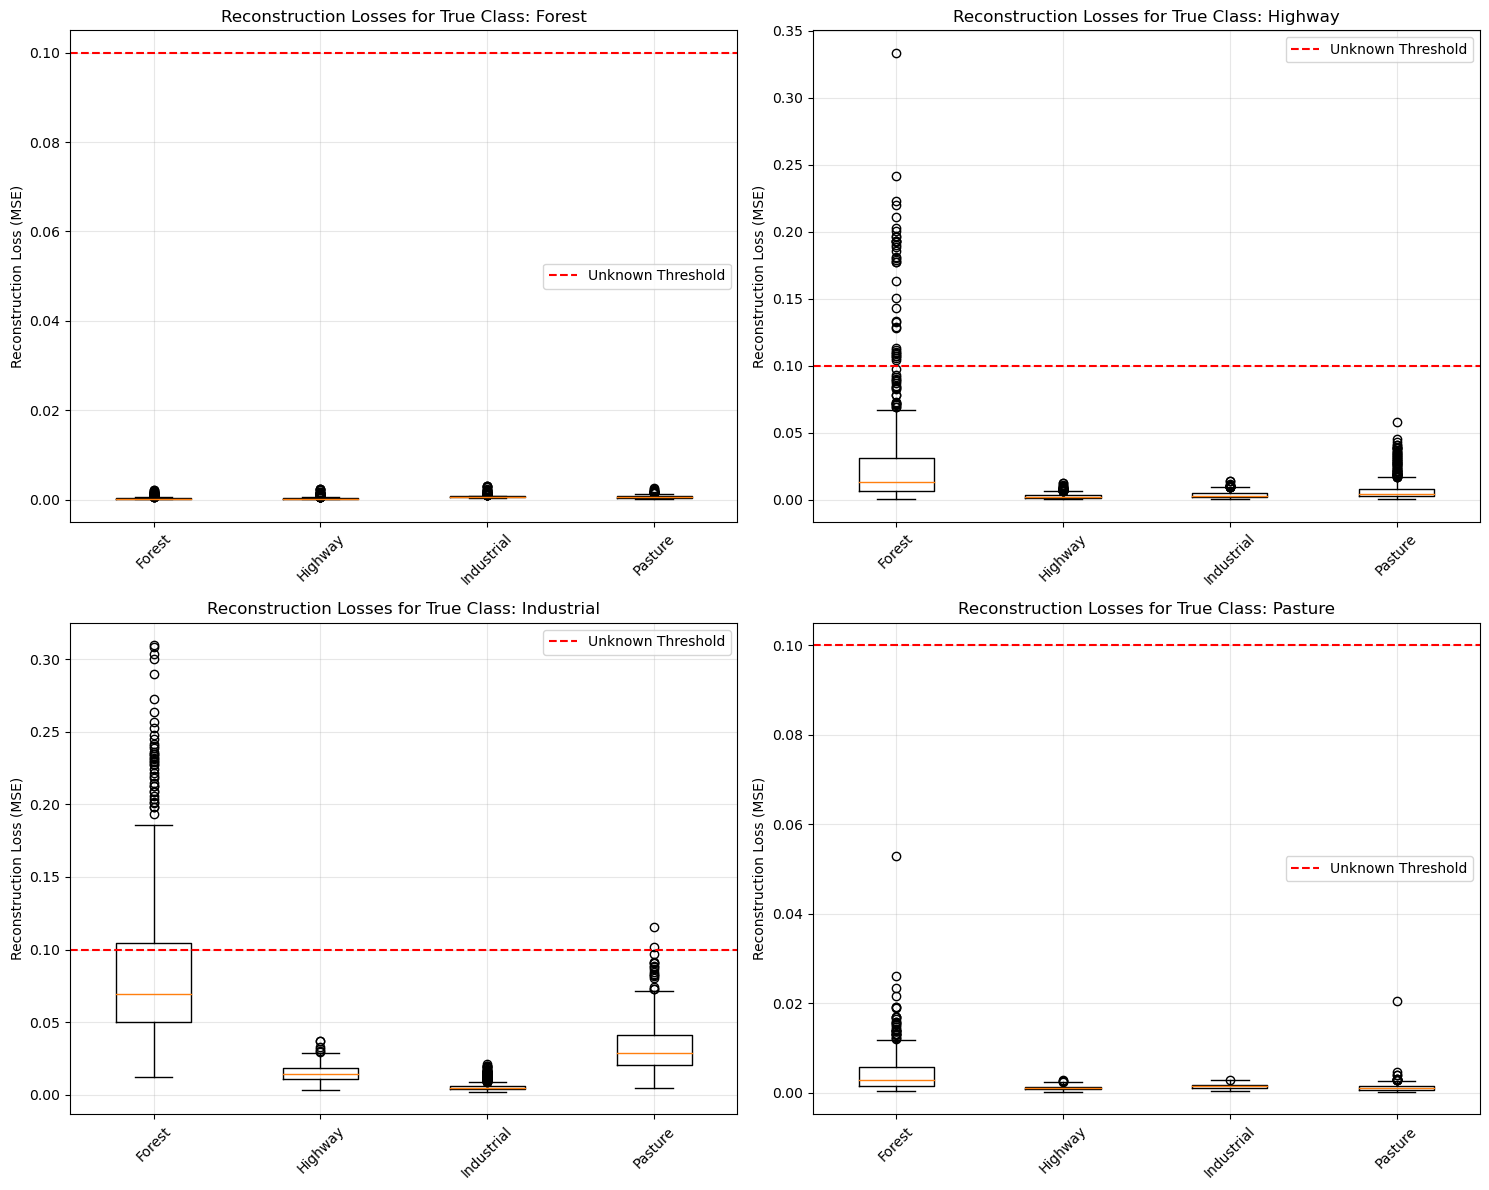

In [35]:
# Plot reconstruction loss distribution for each class
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, class_name in enumerate(CLASSES):
    class_idx = class_to_idx[class_name]
    
    # Get losses for this class
    class_losses = losses_matrix[np.array(true_labels) == class_idx]
    
    # Plot boxplot for all autoencoders
    axes[idx].boxplot([class_losses[:, i] for i in range(len(CLASSES))],
                       labels=CLASSES)
    axes[idx].axhline(y=UNKNOWN_THRESHOLD, color='r', linestyle='--', label='Unknown Threshold')
    axes[idx].set_ylabel('Reconstruction Loss (MSE)')
    axes[idx].set_title(f'Reconstruction Losses for True Class: {class_name}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('reconstruction_loss_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Threshold Optimization

Testing different thresholds...


100%|██████████| 50/50 [00:00<00:00, 123.76it/s]



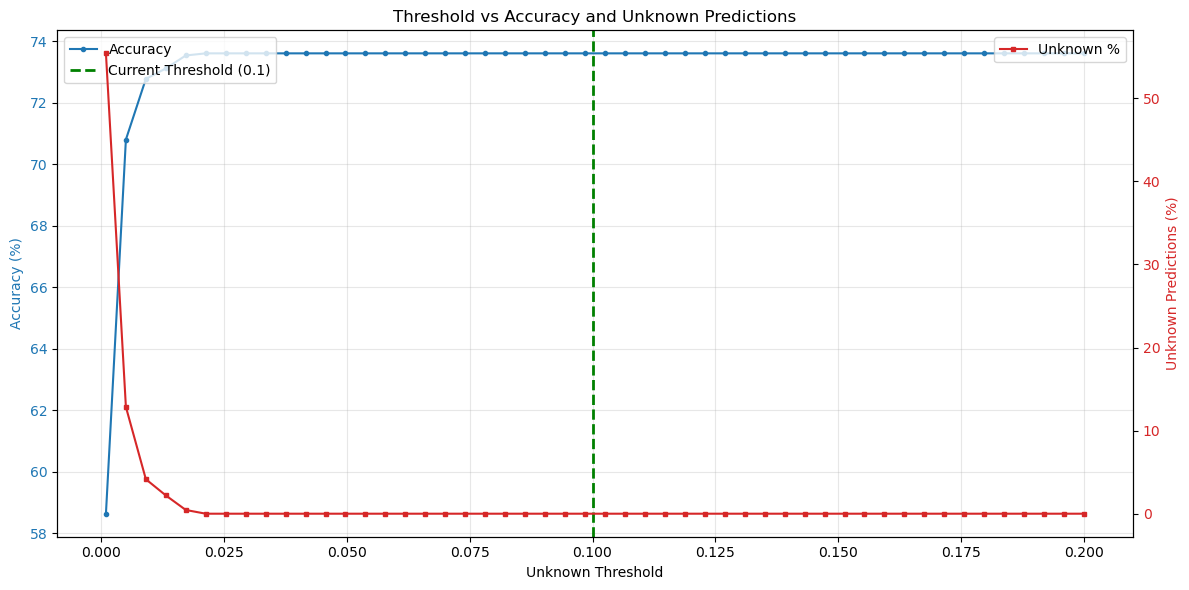


Optimal threshold: 0.021306
Best accuracy: 73.60%
Unknown predictions at optimal threshold: 0.00%


In [36]:
# Test different thresholds
thresholds = np.linspace(0.001, 0.2, 50)
accuracies = []
unknown_percentages = []

print("Testing different thresholds...")
for threshold in tqdm(thresholds):
    temp_pred_labels = []
    unknown_count = 0
    
    for i in range(len(true_labels)):
        min_loss = min(losses_matrix[i])
        
        if min_loss > threshold:
            temp_pred_labels.append(len(CLASSES))  # Unknown
            unknown_count += 1
        else:
            predicted_idx = np.argmin(losses_matrix[i])
            temp_pred_labels.append(predicted_idx)
    
    # Calculate accuracy (excluding unknown)
    filtered_true = [t for t, p in zip(true_labels, temp_pred_labels) if p < len(CLASSES)]
    filtered_pred = [p for p in temp_pred_labels if p < len(CLASSES)]
    
    if len(filtered_true) > 0:
        acc = accuracy_score(filtered_true, filtered_pred)
    else:
        acc = 0
    
    accuracies.append(acc)
    unknown_percentages.append(100 * unknown_count / len(true_labels))

# Plot results
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Unknown Threshold')
ax1.set_ylabel('Accuracy (%)', color='tab:blue')
ax1.plot(thresholds, np.array(accuracies) * 100, color='tab:blue', marker='o', markersize=3, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Unknown Predictions (%)', color='tab:red')
ax2.plot(thresholds, unknown_percentages, color='tab:red', marker='s', markersize=3, label='Unknown %')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Mark current threshold
ax1.axvline(x=UNKNOWN_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Current Threshold ({UNKNOWN_THRESHOLD})')

plt.title('Threshold vs Accuracy and Unknown Predictions')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

# Find optimal threshold
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]
print(f"\nOptimal threshold: {best_threshold:.6f}")
print(f"Best accuracy: {best_accuracy*100:.2f}%")
print(f"Unknown predictions at optimal threshold: {unknown_percentages[best_idx]:.2f}%")

## 14. Visualize Classification Examples

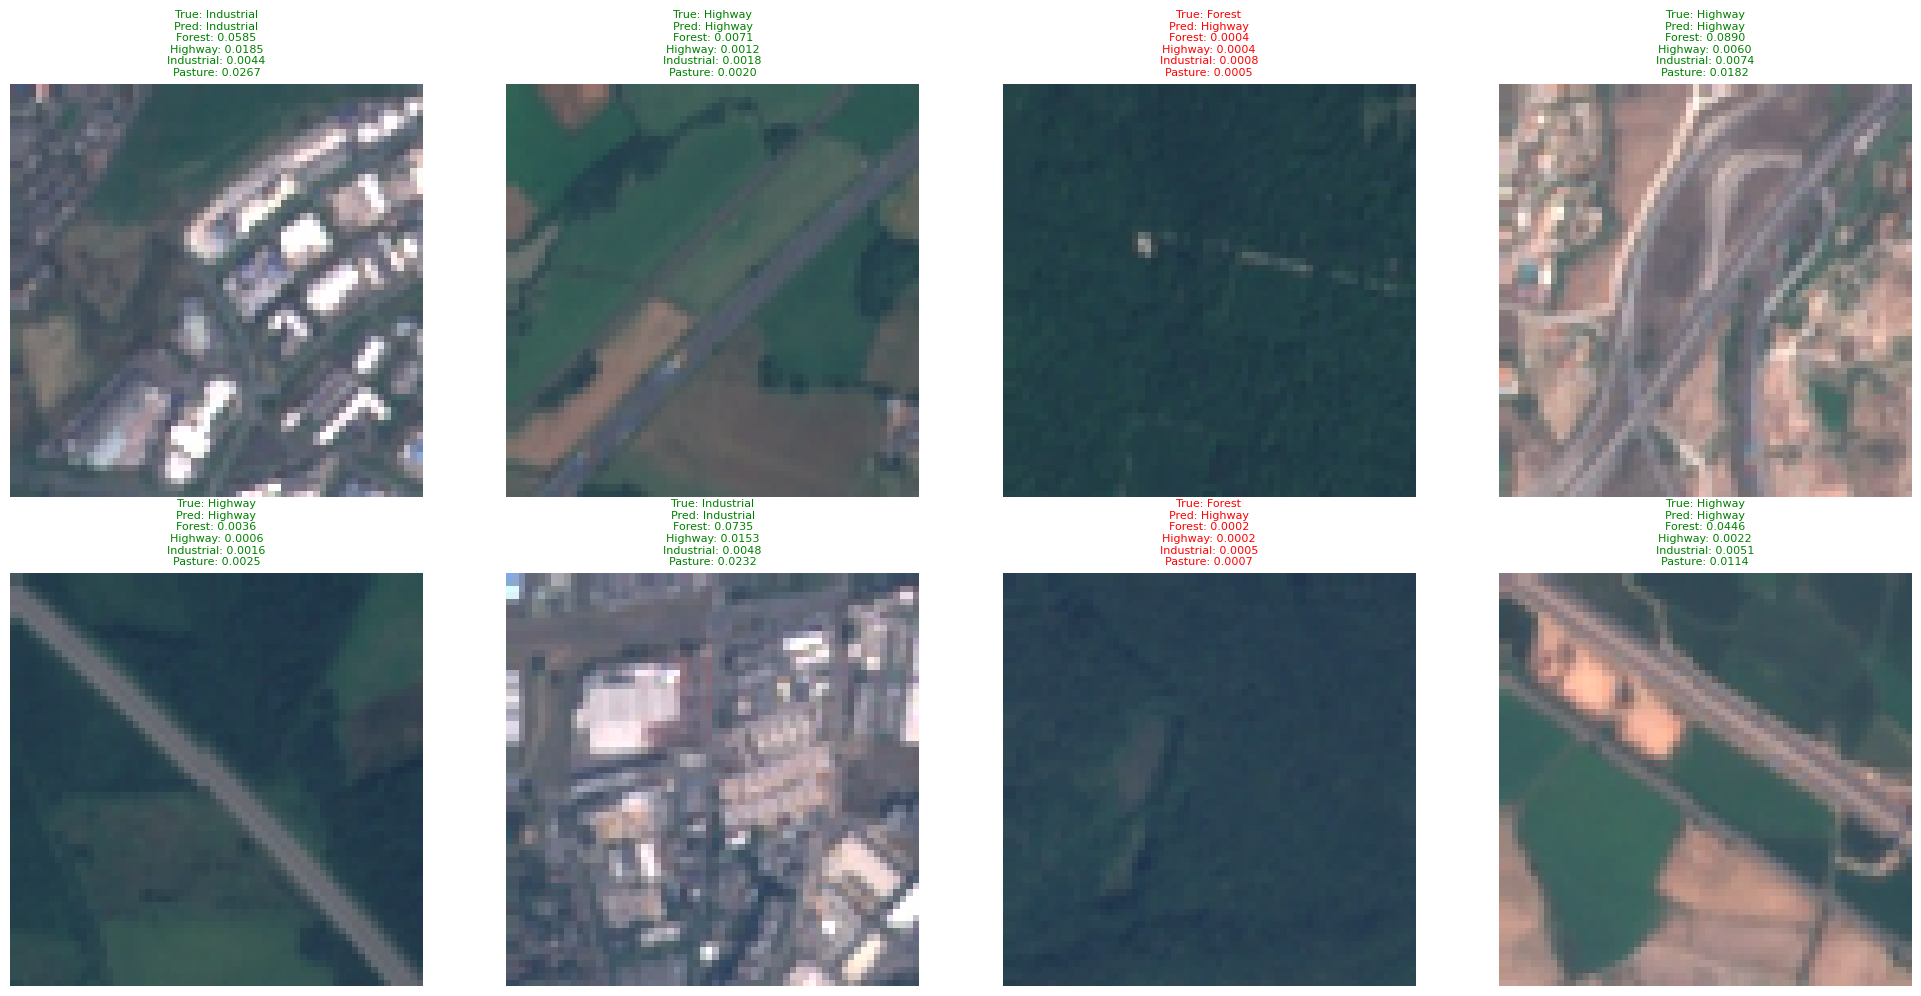

In [37]:
def visualize_classification_examples(autoencoders, val_loader, classes, unknown_threshold, num_examples=8):
    """Visualize classification examples with reconstruction losses"""
    
    examples_collected = 0
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for images, labels in val_loader:
        images = images.to(device)
        
        for i in range(len(images)):
            if examples_collected >= num_examples:
                break
            
            image = images[i:i+1]
            true_label = classes[labels[i]]
            
            # Classify
            predicted, losses, min_loss = classify_image(
                image, autoencoders, classes, unknown_threshold
            )
            
            # Display image
            img_display = image[0].cpu().numpy().transpose(1, 2, 0)
            axes[examples_collected].imshow(np.clip(img_display, 0, 1))
            
            # Create title with losses
            title = f"True: {true_label}\nPred: {predicted}\n"
            title += "\n".join([f"{cls}: {losses[cls]:.4f}" for cls in classes])
            
            color = 'green' if (predicted == true_label or (isinstance(predicted, list) and true_label in predicted)) else 'red'
            axes[examples_collected].set_title(title, fontsize=8, color=color)
            axes[examples_collected].axis('off')
            
            examples_collected += 1
        
        if examples_collected >= num_examples:
            break
    
    plt.tight_layout()
    plt.savefig('classification_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_classification_examples(autoencoders, combined_val_loader, CLASSES, UNKNOWN_THRESHOLD)

## 15. Test on Out-of-Distribution (OOD) Data

Testing on Out-of-Distribution data...

OOD classes found: ['DenseResidential', 'Forest', 'MediumResidential']

Loaded 30 images for class 'DenseResidential'
OOD Class: DenseResidential
  Total images: 30
  Predicted as 'Unknown': 0 (0.00%)
  Predicted as 'Forest': 0 (0.00%)
  Predicted as 'Highway': 13 (43.33%)
  Predicted as 'Industrial': 15 (50.00%)
  Predicted as 'Pasture': 2 (6.67%)

Loaded 60 images for class 'Forest'
OOD Class: DenseResidential
  Total images: 30
  Predicted as 'Unknown': 0 (0.00%)
  Predicted as 'Forest': 0 (0.00%)
  Predicted as 'Highway': 13 (43.33%)
  Predicted as 'Industrial': 15 (50.00%)
  Predicted as 'Pasture': 2 (6.67%)

Loaded 60 images for class 'Forest'
OOD Class: Forest
  Total images: 60
  Predicted as 'Unknown': 0 (0.00%)
  Predicted as 'Forest': 0 (0.00%)
  Predicted as 'Highway': 21 (35.00%)
  Predicted as 'Industrial': 6 (10.00%)
  Predicted as 'Pasture': 33 (55.00%)

Loaded 30 images for class 'MediumResidential'
OOD Class: Forest
  Total imag

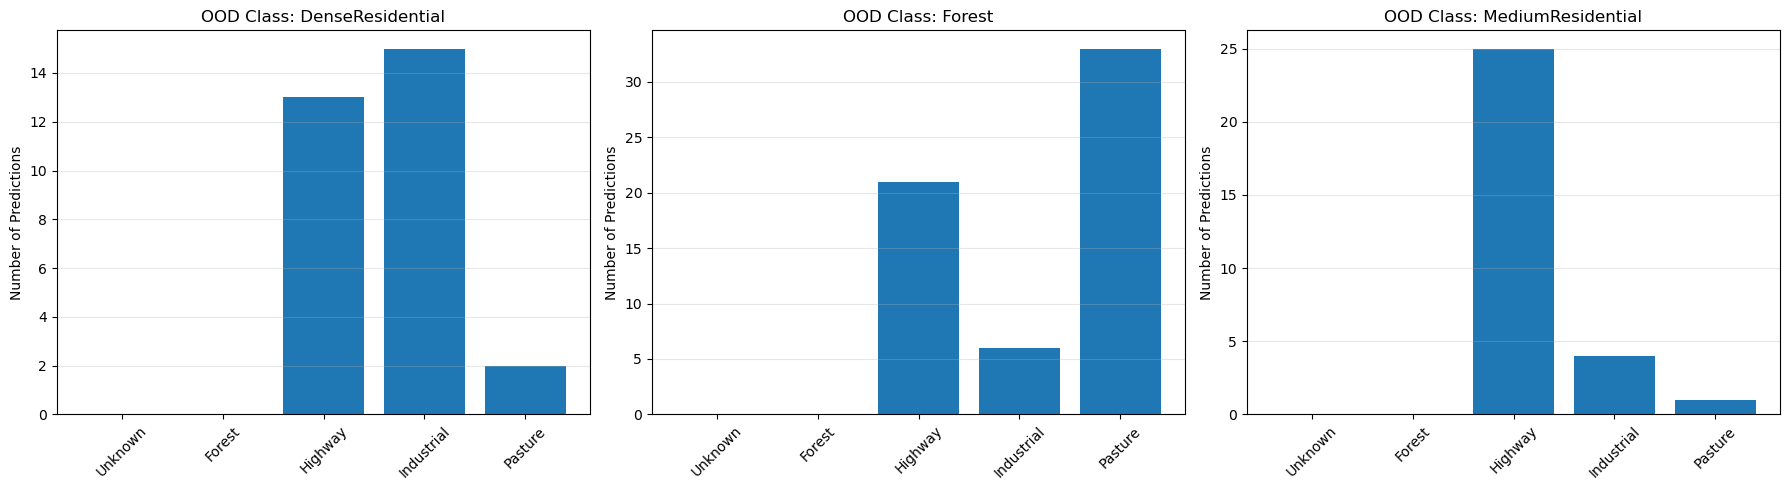

In [38]:
# Load OOD data if available
OOD_PATH = os.path.join(DATA_ROOT, "OOD")

if os.path.exists(OOD_PATH):
    print("Testing on Out-of-Distribution data...\n")
    
    # Get OOD classes
    ood_classes = [d for d in os.listdir(OOD_PATH) if os.path.isdir(os.path.join(OOD_PATH, d))]
    print(f"OOD classes found: {ood_classes}\n")
    
    ood_results = {}
    
    for ood_class in ood_classes:
        ood_class_path = os.path.join(OOD_PATH, ood_class)
        
        # Load OOD data
        ood_dataset = SingleClassDataset(OOD_PATH, ood_class, transform=val_transforms)
        ood_loader = DataLoader(ood_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        # Classify OOD images
        ood_predictions = {'Unknown': 0}
        for cls in CLASSES:
            ood_predictions[cls] = 0
        
        total_ood = 0
        ood_losses = []
        
        for images, _ in ood_loader:
            images = images.to(device)
            
            for i in range(len(images)):
                image = images[i:i+1]
                predicted, losses, min_loss = classify_image(
                    image, autoencoders, CLASSES, UNKNOWN_THRESHOLD
                )
                
                if predicted == 'Unknown':
                    ood_predictions['Unknown'] += 1
                elif isinstance(predicted, list):
                    for pred_cls in predicted:
                        ood_predictions[pred_cls] += 1
                else:
                    ood_predictions[predicted] += 1
                
                ood_losses.append([losses[cls] for cls in CLASSES])
                total_ood += 1
        
        ood_results[ood_class] = {
            'predictions': ood_predictions,
            'total': total_ood,
            'losses': np.array(ood_losses)
        }
        
        print(f"OOD Class: {ood_class}")
        print(f"  Total images: {total_ood}")
        for pred_cls, count in ood_predictions.items():
            percentage = 100 * count / total_ood
            print(f"  Predicted as '{pred_cls}': {count} ({percentage:.2f}%)")
        print()
    
    # Visualize OOD results
    if ood_results:
        fig, axes = plt.subplots(1, len(ood_results), figsize=(6*len(ood_results), 5))
        if len(ood_results) == 1:
            axes = [axes]
        
        for idx, (ood_class, results) in enumerate(ood_results.items()):
            pred_classes = list(results['predictions'].keys())
            pred_counts = [results['predictions'][cls] for cls in pred_classes]
            
            axes[idx].bar(pred_classes, pred_counts)
            axes[idx].set_title(f'OOD Class: {ood_class}')
            axes[idx].set_ylabel('Number of Predictions')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('ood_predictions.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print(f"OOD data not found at {OOD_PATH}")

## 16. Save Complete System

In [39]:
# Save all models and configuration
system_config = {
    'classes': CLASSES,
    'latent_dim': LATENT_DIM,
    'img_size': IMG_SIZE,
    'unknown_threshold': UNKNOWN_THRESHOLD,
    'multi_label_threshold': MULTI_LABEL_THRESHOLD,
    'best_val_losses': best_val_losses,
    'histories': histories
}

with open('autoencoder_system_config.json', 'w') as f:
    json.dump({k: v for k, v in system_config.items() if k != 'histories'}, f, indent=2)

print("System configuration saved!")
print(f"\nAutoencoder models saved:")
for class_name in CLASSES:
    print(f"  - autoencoder_{class_name.lower()}.pth")

System configuration saved!

Autoencoder models saved:
  - autoencoder_forest.pth
  - autoencoder_highway.pth
  - autoencoder_industrial.pth
  - autoencoder_pasture.pth


## 17. Summary

In [40]:
print("="*70)
print("EXPERT AUTOENCODER CLASSIFIER SUMMARY")
print("="*70)
print(f"\nApproach: One autoencoder per class")
print(f"Classes: {', '.join(CLASSES)}")
print(f"\nBest Validation Losses (Reconstruction MSE):")
for class_name, loss in best_val_losses.items():
    print(f"  {class_name:15s}: {loss:.6f}")
print(f"\nClassification Strategy:")
print(f"  - Compute reconstruction loss for each autoencoder")
print(f"  - Assign class with minimum reconstruction loss")
print(f"  - If all losses > {UNKNOWN_THRESHOLD:.4f}, classify as 'Unknown'")
print(f"\nValidation Results:")
if len(filtered_true) > 0:
    print(f"  Accuracy (excluding Unknown): {accuracy_score(filtered_true, filtered_pred)*100:.2f}%")
unknown_pct = 100 * sum(1 for p in pred_labels if p == len(CLASSES)) / len(pred_labels)
print(f"  Images classified as Unknown: {unknown_pct:.2f}%")
print(f"\nAdvantages:")
print(f"  ✓ Can detect out-of-distribution samples")
print(f"  ✓ Interpretable (based on reconstruction quality)")
print(f"  ✓ Can support multi-label classification")
print(f"  ✓ Each autoencoder is an expert for its class")
print("="*70)

EXPERT AUTOENCODER CLASSIFIER SUMMARY

Approach: One autoencoder per class
Classes: Forest, Highway, Industrial, Pasture

Best Validation Losses (Reconstruction MSE):
  Forest         : 0.000346
  Highway        : 0.003739
  Industrial     : 0.010728
  Pasture        : 0.001194

Classification Strategy:
  - Compute reconstruction loss for each autoencoder
  - Assign class with minimum reconstruction loss
  - If all losses > 0.1000, classify as 'Unknown'

Validation Results:
  Accuracy (excluding Unknown): 73.60%
  Images classified as Unknown: 0.00%

Advantages:
  ✓ Can detect out-of-distribution samples
  ✓ Interpretable (based on reconstruction quality)
  ✓ Can support multi-label classification
  ✓ Each autoencoder is an expert for its class
